# AML- MovieRatingPrediction - Random Forest

## Preprocess

Using Genre Handling Version 2 (one genre per observation, each film may takes multiple rows), because no significant MSE difference observed, while the computation is fewer.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns

# read
basics_df = pd.read_csv('./title.basics.tsv.gz', delimiter="\t")
basics_movies_df =  basics_df[basics_df.titleType=="movie"]
ratings_df = pd.read_csv('./title.ratings.tsv.gz', delimiter="\t")

# merge
movie_df = basics_movies_df.merge(ratings_df, on='tconst', how='left')
movie_df=movie_df.drop(columns=["endYear", "titleType",
                                "tconst", "originalTitle"])

# NAs and data types
movie_df.replace(["\\N"],np.nan,inplace=True)
movie_df=movie_df.dropna()
movie_df["startYear"] = pd.to_numeric(movie_df["startYear"])
movie_df["runtimeMinutes"] = pd.to_numeric(movie_df["runtimeMinutes"])
movie_df["isAdult"] = pd.to_numeric(movie_df["isAdult"])

# encode
movie_oh = pd.concat([movie_df.drop(columns="genres"),
                      movie_df["genres"].str.get_dummies(sep=",")],
                      axis=1)

# split
X = movie_oh.drop(columns=["averageRating", "primaryTitle"])
y = movie_oh["averageRating"]
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=42,
                                                test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev,
                                                  random_state=42,
                                                  test_size=0.25)

# Standardize?


/var/folders/b5/x127tcr10t39rfngm9vkr2640000gn/T/ipykernel_56347/3676800120.py:9: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  basics_df = pd.read_csv('./title.basics.tsv.gz', delimiter="\t")


## Baseline

In [2]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_dev, y_dev)
rf_y_predict = rf.predict(X_test)
print(f"Random Forest MSE = ", mean_squared_error(y_test,rf_y_predict))
print(f"Random Forest R^2 = ", r2_score(y_test,rf_y_predict))

Random Forest MSE =  1.324596261156363


/Users/luotongkang/opt/anaconda3/envs/4995aml/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/b5/x127tcr10t39rfngm9vkr2640000gn/T/ipykernel_56347/3801210230.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

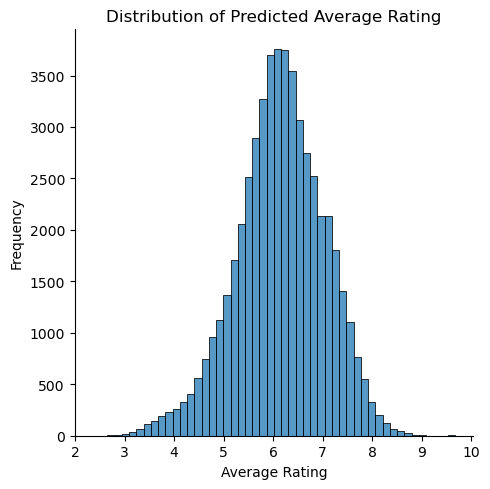

In [12]:
plt.figure(figsize=(12,8))
sns.displot(rf_y_predict, bins=50)
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Average Rating')
plt.show()

## Hyperparameter Tuning

We choose to tune `n_estimators` and `max_depth`. There are two kinds of hyperparameters we can control: forest hyperparameter and decision tree hyperparameter. We would want to control both the splitting process and the tree formation. The `n_estimators` controls the number of trees in the forest, and `max_depth` prunes the each decision tree to avoid overfitting.

In [7]:
from sklearn.model_selection import GridSearchCV
random_grid = {'max_depth': [2, 4, 6, 8, 10],
               'n_estimators': [50, 100, 150, 200, 250]}
rf_cv = GridSearchCV(RandomForestRegressor(random_state=42),
                     param_grid=random_grid,
                     return_train_score=True,
                     scoring="r2")
rf_cv.fit(X_dev, y_dev)
print(f"Best R^2 Score:", rf_cv.best_score_)
print(f"Best depth:", rf_cv.best_params_)
print(f"Test R^2 score:", rf_cv.score(X_test, y_test))

Best R^2 Score: 0.31917891900575635
Best depth: {'max_depth': 10, 'n_estimators': 250}
Test R^2 score: 0.317208404582522


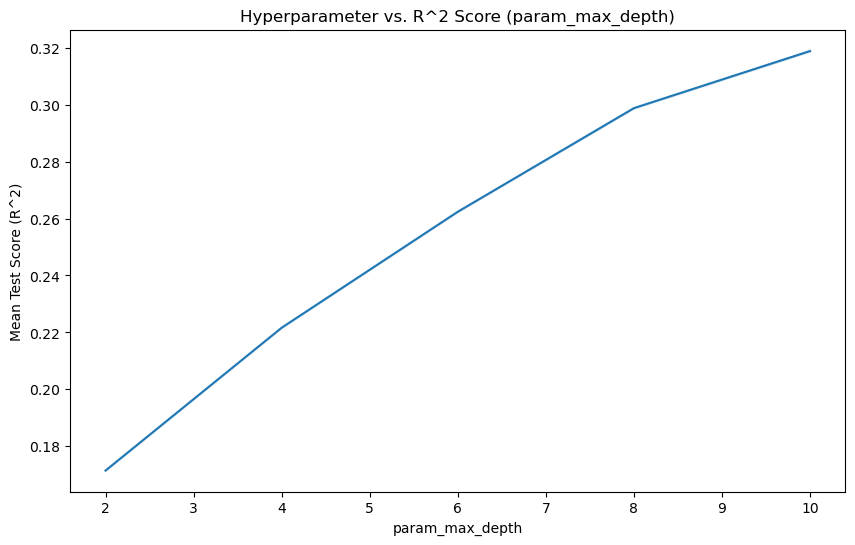

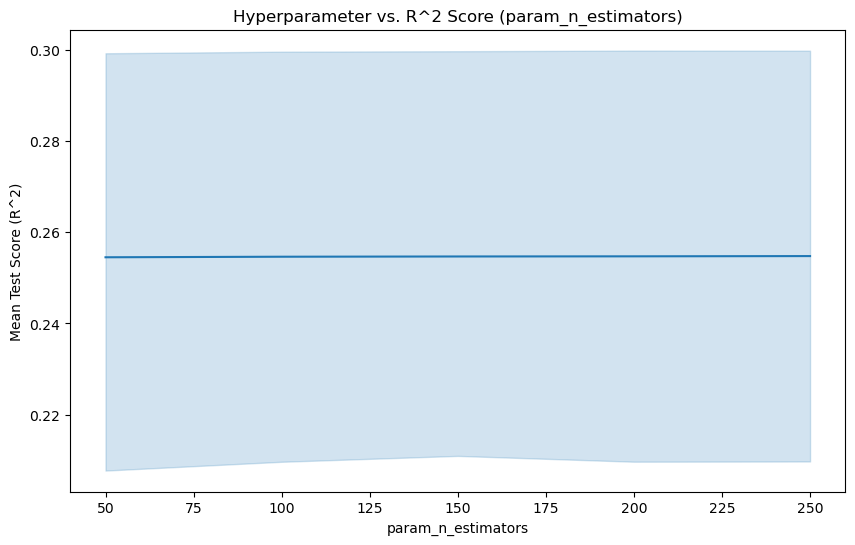

In [8]:
# Extract the results
results = pd.DataFrame(rf_cv.cv_results_)

# Plot hyperparameter vs. R^2 score graphs
hyperparameters = ['param_' + param for param in random_grid.keys()]

for hyperparameter in hyperparameters:
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=hyperparameter, y='mean_test_score', data=results)
    plt.title(f'Hyperparameter vs. R^2 Score ({hyperparameter})')
    plt.xlabel(hyperparameter)
    plt.ylabel('Mean Test Score (R^2)')
    plt.show()

## Feature Importance

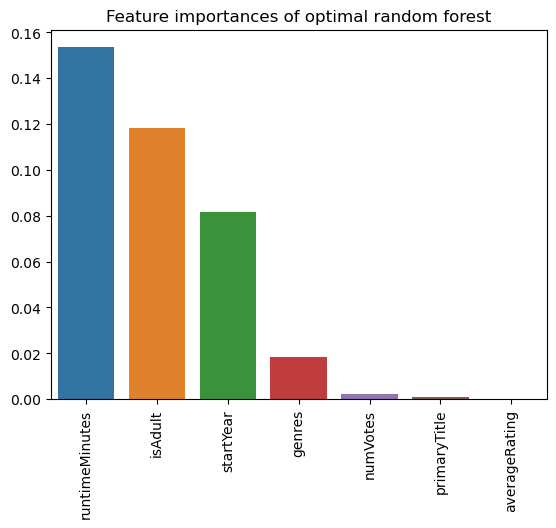

In [10]:
feat_imps = zip(movie_df.columns, rf_cv.best_estimator_.feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)),
                           key=lambda x: x[1], reverse=True)))
sns.barplot(x=list(feats), y=list(imps))
plt.tick_params (axis='x', rotation=90)
plt.title("Feature importances of optimal random forest")
plt.show()